1 - Logistic model where birth rate depends on size; Gillespie algorithm used

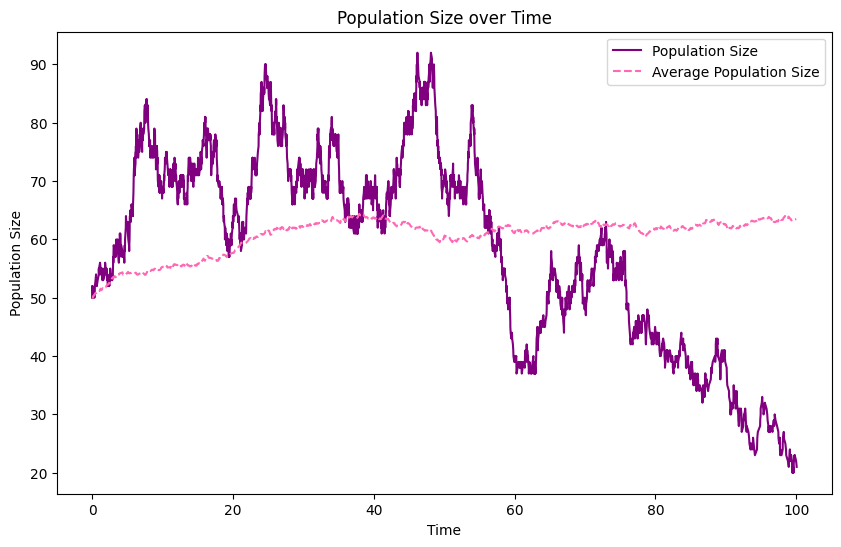

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random

def set_parameters(initial_population, birth_rate=None, death_rate=None, max_time=100, carrying_capacity=500, max_population=None):
    if birth_rate is None:
        birth_rate = random.uniform(0.1, 0.5)
    if death_rate is None:
        death_rate = random.uniform(0.1, 0.5)

    return {
        'initial_population': initial_population,
        'birth_rate': birth_rate,
        'death_rate': death_rate,
        'max_time': max_time,
        'carrying_capacity': carrying_capacity,
        'max_population': max_population
    }

def run_simulation(params):
    time = 0
    population = params['initial_population']
    max_population = params['max_population']
    carrying_capacity = params['carrying_capacity']

    time_points = [time]
    population_sizes = [population]

    while time < params['max_time'] and population > 0:
        effective_birth_rate = params['birth_rate'] * (1 - population / carrying_capacity)
        birth_rate_total = effective_birth_rate * population
        death_rate_total = params['death_rate'] * population
        total_rate = birth_rate_total + death_rate_total

        if total_rate == 0:
            break

        time_to_next_event = np.random.exponential(1 / total_rate)

        if random.uniform(0, 1) < birth_rate_total / total_rate:
            population += 1
        else:
            population -= 1

        time += time_to_next_event

        if max_population and population > max_population:
            break

        time_points.append(time)
        population_sizes.append(population)

    return time_points, population_sizes

def run_multiple_simulations(params, num_simulations):
    all_time_points = []
    all_population_sizes = []

    for _ in range(num_simulations):
        time_points, population_sizes = run_simulation(params)
        all_time_points.append(time_points)
        all_population_sizes.append(population_sizes)

    max_time = params['max_time']
    num_points = 1000  # Number of points for interpolation
    average_time_points = np.linspace(0, max_time, num_points)
    interpolated_populations = np.zeros((num_simulations, num_points))

    for i in range(num_simulations):
        interpolated_populations[i] = np.interp(average_time_points, all_time_points[i], all_population_sizes[i])

    average_population_sizes = np.mean(interpolated_populations, axis=0)

    return average_time_points, average_population_sizes

def plot_results(time_points, population_sizes, average_time_points=None, average_population_sizes=None):
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, population_sizes, color='purple', label='Population Size')

    if average_time_points is not None and average_population_sizes is not None:
        plt.plot(average_time_points, average_population_sizes, color='hotpink', label='Average Population Size', linestyle='--')

    plt.xlabel('Time')
    plt.ylabel('Population Size')
    plt.title('Population Size over Time')
    plt.legend()
    plt.show()

# Example usage
params = set_parameters(initial_population=50)
time_points, population_sizes = run_simulation(params)
average_time_points, average_population_sizes = run_multiple_simulations(params, num_simulations=100)
plot_results(time_points, population_sizes, average_time_points, average_population_sizes)



2 - Multiple simulations, quantiles added

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def set_parameters(initial_population=50, birth_rate=0.1, death_rate=0.1, competition_coefficient=0.01, carrying_capacity=500, max_time=100):
    return {
        'initial_population': initial_population,
        'birth_rate': birth_rate,
        'death_rate': death_rate,
        'carrying_capacity': carrying_capacity,
        'max_time': max_time
    }

def run_simulation(params):
    population = params['initial_population']
    birth_rate = params['birth_rate']
    death_rate = params['death_rate']
    max_time = params['max_time']
    carrying_capacity = params['carrying_capacity']
    
    time_points = [0]
    population_sizes = [population]
    
    while population > 0 and time_points[-1] < max_time:
        effective_birth_rate = params['birth_rate'] * (1 - population / carrying_capacity) + params['death_rate']*(population/carrying_capacity)
        next_event_time = np.random.exponential(1 / (death_rate*population + effective_birth_rate*population))
        
        
        # if birth_event_time < death_event_time:
        if np.random.rand() < effective_birth_rate / (effective_birth_rate + death_rate):
            population += 1
        else:
            population -= 1
        
        time_points.append(time_points[-1] + next_event_time)
        population_sizes.append(population)
    
    return time_points, population_sizes


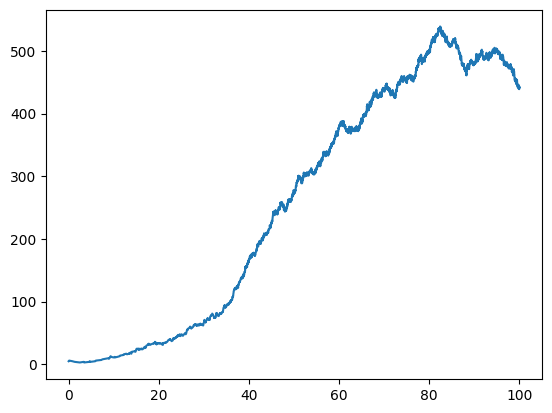

In [11]:

params = set_parameters(initial_population=5, birth_rate=0.2,death_rate=0.1,carrying_capacity=500)
time_points, population_sizes = run_simulation(params)

plt.plot(time_points, population_sizes)

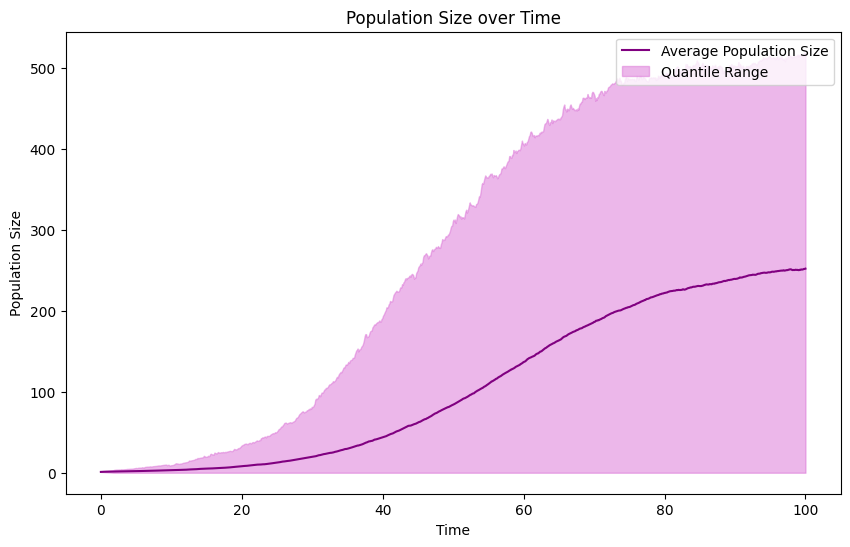

Extinction Probability: 0.48


In [12]:

def run_multiple_simulations_with_quantiles(params, num_simulations=100):
    all_time_points = []
    all_population_sizes = []
    extinction_count = 0
    max_time = params['max_time']
    
    for _ in range(num_simulations):
        time_points, population_sizes = run_simulation(params)
        all_time_points.append(time_points)
        all_population_sizes.append(population_sizes)
        if population_sizes[-1] == 0:
            extinction_count += 1
    
    # Calculate quantiles
    max_len = max(len(sim) for sim in all_population_sizes)
    num_points = 1000  # Number of points for interpolation
    average_time_points = np.linspace(0, max_time, num_points)
    interpolated_populations = np.zeros((num_simulations, num_points))
    for i in range(num_simulations):
        interpolated_populations[i] = np.interp(average_time_points, all_time_points[i], all_population_sizes[i])
    average_population_sizes = np.mean(interpolated_populations, axis=0)
    lower_quantile = np.nanquantile(interpolated_populations, 0.05, axis=0)
    upper_quantile = np.nanquantile(interpolated_populations, 0.95, axis=0)
    
    extinction_probability = extinction_count / num_simulations
    
    return average_time_points, interpolated_populations, average_population_sizes, lower_quantile, upper_quantile, extinction_probability

def plot_multiple_simulations_with_quantiles(average_time_points, interpolated_populations, average_population_sizes, lower_quantile, upper_quantile):
    plt.figure(figsize=(10, 6))

    plt.plot(average_time_points, average_population_sizes, color='purple', linestyle='-', label='Average Population Size')
    plt.fill_between(average_time_points, lower_quantile, upper_quantile, color='orchid', alpha=0.5, label='Quantile Range')
    
    plt.xlabel('Time')
    plt.ylabel('Population Size')
    plt.title('Population Size over Time')
    plt.legend()
    plt.show()

# Example usage
params = set_parameters(initial_population=1, birth_rate=0.2, death_rate=0.1)

# Multiple simulations\
num_simulations = 100
all_time_points, all_population_sizes, average_population_sizes, lower_quantile, upper_quantile, extinction_probability = run_multiple_simulations_with_quantiles(params, num_simulations)

# Plot results
plot_multiple_simulations_with_quantiles(all_time_points, all_population_sizes, average_population_sizes, lower_quantile, upper_quantile)

# Print extinction probability
print(f"Extinction Probability: {extinction_probability:.2f}")

3 - Same model but with individual growth curves plotted

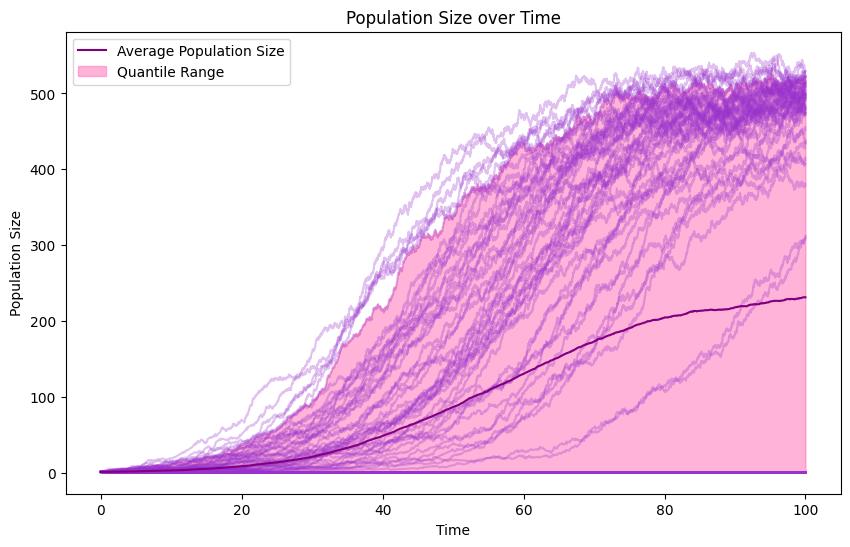

Extinction Probability: 0.52


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def set_parameters(initial_population=50, birth_rate=0.1, death_rate=0.1, carrying_capacity=500, max_time=100):
    return {
        'initial_population': initial_population,
        'birth_rate': birth_rate,
        'death_rate': death_rate,
        'carrying_capacity': carrying_capacity,
        'max_time': max_time
    }

def run_simulation(params):
    population = params['initial_population']
    birth_rate = params['birth_rate']
    death_rate = params['death_rate']
    max_time = params['max_time']
    carrying_capacity = params['carrying_capacity']

    time_points = [0]
    population_sizes = [population]

    while population > 0 and time_points[-1] < max_time:
        effective_birth_rate = params['birth_rate'] * (1 - population / carrying_capacity) + params['death_rate'] * (population / carrying_capacity)
        next_event_time = np.random.exponential(1 / (death_rate * population + effective_birth_rate * population))
        
        if np.random.rand() < effective_birth_rate / (effective_birth_rate + death_rate):
            population += 1
        else:
            population -= 1

        time_points.append(time_points[-1] + next_event_time)
        population_sizes.append(population)

    return time_points, population_sizes

def run_multiple_simulations_with_quantiles(params, num_simulations=100):
    all_time_points = []
    all_population_sizes = []
    extinction_count = 0
    max_time = params['max_time']

    for _ in range(num_simulations):
        time_points, population_sizes = run_simulation(params)
        all_time_points.append(time_points)
        all_population_sizes.append(population_sizes)
        if population_sizes[-1] == 0:
            extinction_count += 1

    max_len = max(len(sim) for sim in all_time_points)
    num_points = max_len
    average_time_points = np.linspace(0, max_time, num_points)

    interpolated_populations = np.zeros((num_simulations, num_points))
    for i in range(num_simulations):
        interpolated_populations[i] = np.interp(average_time_points, all_time_points[i], all_population_sizes[i])
    average_population_sizes = np.mean(interpolated_populations, axis=0)
    lower_quantile = np.nanquantile(interpolated_populations, 0.05, axis=0)
    upper_quantile = np.nanquantile(interpolated_populations, 0.95, axis=0)

    extinction_probability = extinction_count / num_simulations

    return average_time_points, interpolated_populations, average_population_sizes, lower_quantile, upper_quantile, extinction_probability

def plot_multiple_simulations_with_quantiles(average_time_points, interpolated_populations, average_population_sizes, lower_quantile, upper_quantile):
    plt.figure(figsize=(10, 6))

    for simulation in interpolated_populations:
        plt.plot(average_time_points, simulation, color='darkorchid', alpha=0.3)

    plt.plot(average_time_points, average_population_sizes, color='purple', linestyle='-', label='Average Population Size')
    plt.fill_between(average_time_points, lower_quantile, upper_quantile, color='hotpink', alpha=0.5, label='Quantile Range')

    plt.xlabel('Time')
    plt.ylabel('Population Size')
    plt.title('Population Size over Time')
    plt.legend()
    plt.show()

# Example usage
params = set_parameters(initial_population=1, birth_rate=0.2, death_rate=0.1)

# Multiple simulations
num_simulations = 100
average_time_points, interpolated_populations, average_population_sizes, lower_quantile, upper_quantile, extinction_probability = run_multiple_simulations_with_quantiles(params, num_simulations)

# Plot results
plot_multiple_simulations_with_quantiles(average_time_points, interpolated_populations, average_population_sizes, lower_quantile, upper_quantile)

# Print extinction probability
print(f"Extinction Probability: {extinction_probability:.2f}")